In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('../'))
sys.path.insert(0, os.path.abspath('../../'))
import warnings
warnings.filterwarnings("ignore")

import cirq
from mitiq import cdr
import mitiq

import numpy as np
from scipy.optimize import minimize
import networkx as nx


import qiskit 
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, QuantumRegister, ClassicalRegister
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.aer import QasmSimulator
from qiskit.algorithms import QAOA
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from shared.QiskitMaxcut import *
from qiskit.utils import QuantumInstance
from qiskit.result import Result
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.algorithms.optimizers import SPSA, COBYLA, QNSPSA
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
%matplotlib inline

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()
provider = qiskit.IBMQ.get_provider(hub='ibm-q-unibw', group='hochschule-muc', project='masterarbeit')

In [2]:
%load_ext autoreload
%autoreload 2

## Clifford data regression Example

https://mitiq.readthedocs.io/en/stable/examples/cdr_api.html

In [3]:
a, b = cirq.LineQubit.range(2)
circuit = cirq.Circuit(
    cirq.rx(0.1).on(a),
    cirq.rx(-0.72).on(b),
    cirq.rz(0.4).on(a),
    cirq.rz(0.2).on(b),
    cirq.CNOT.on(a, b),
    cirq.rx(-0.1).on(b),
    cirq.rz(-0.23).on(a),
    cirq.CNOT.on(b, a),
    cirq.rx(-0.112).on(a),
    cirq.measure(a, b, key="z"),
)
circuit

0: ───Rx(0.032π)────Rz(0.127π)───@───Rz(-0.073π)───X───Rx(-0.036π)───M('z')───
                                 │                 │                 │
1: ───Rx(-0.229π)───Rz(0.064π)───X───Rx(-0.032π)───@─────────────────M────────

In [4]:
from typing import Counter


def sample_bitstrings(circ: cirq.Circuit, shots: int = 1000, noise: float = 0.01) -> Counter[int]:
    # Add depolarizing noise to emulate a noisy quantum processor!
    circuit = circ.with_noise(cirq.depolarize(noise))
    
    return cirq.DensityMatrixSimulator().run(circuit, repetitions=shots).histogram(key="z")

In [5]:
sample_bitstrings(circuit)

Counter({1: 23, 0: 782, 3: 167, 2: 28})

In [6]:
# Observable(s) to measure.
z = np.diag([1, -1])
obs = np.diag(np.kron(z, z))

In [7]:
def sample_bitstrings_simulator(circuit, shots: int = 1000) -> Counter:
    return sample_bitstrings(circuit, shots=shots, noise=0.0)

In [8]:
cdr.execute.calculate_observable(
    state_or_measurements=sample_bitstrings_simulator(circuit),
    observable=obs,
)

0.98

In [9]:
cdr.execute.calculate_observable(
    state_or_measurements=sample_bitstrings(circuit),
    observable=obs,
)

0.886

In [10]:
cdr.execute_with_cdr(
    circuit=circuit,
    executor=sample_bitstrings,
    observables=[obs],
    simulator=sample_bitstrings_simulator,
)

[0.994]

## QAOA Butterfly Example

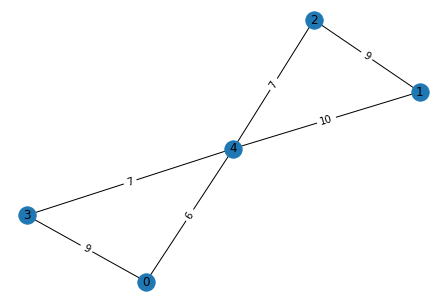

In [11]:
from ibm.ibm_parameters import *
G = generate_butterfly_graph(with_weights=True)
max_cut = Maxcut(G,-35)
max_cut.draw()
qubo = max_cut.to_qubo()

### Create Circuit 

In [12]:
# todo: maybe convert to specific gates 
qaoa = QAOA(quantum_instance=Aer.get_backend('qasm_simulator'), initial_point=[ -3.33412359,  5.45892711])
algorithm = MinimumEigenOptimizer(qaoa)
result = algorithm.solve(qubo)
param_dict = dict(zip(qaoa._ansatz_params, qaoa._initial_point))  # type: Dict
wave_function = qaoa.ansatz.assign_parameters(param_dict)

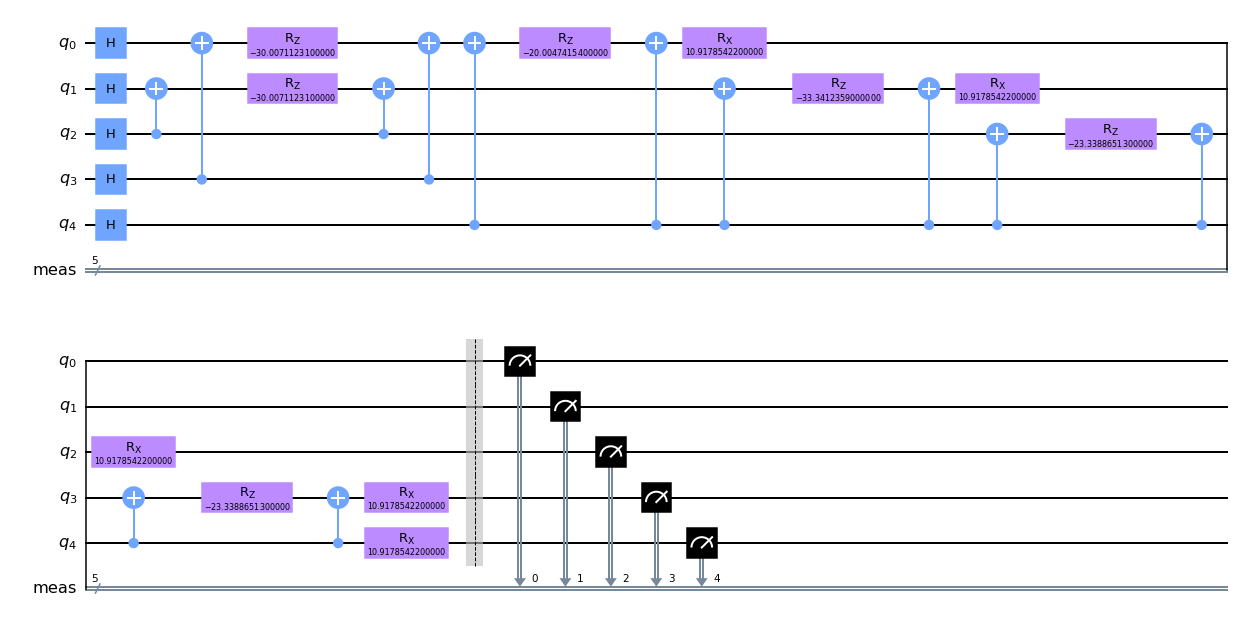

In [13]:
circuit = wave_function.copy()
circuit.measure_all()
circuit.draw('mpl')

### Helper functions 

In [14]:
import qiskit 
from qiskit.providers.aer.noise import NoiseModel
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter

noise_backend = provider.get_backend("ibmq_toronto")
noise_model = NoiseModel.from_backend(noise_backend)
coupling_map = noise_backend.configuration().coupling_map
basis_gates = noise_model.basis_gates

def sample_bitstrings(circuit, shots: int = 1024) -> Dict[int, int]:
    # Add depolarizing noise to emulate a noisy quantum processor!
    # Use Aer's qasm_simulator
    print("run noise")
    circuit.name = ""
    if type(circuit) == cirq.circuits.circuit.Circuit:
        circuit = mitiq.interface.mitiq_qiskit.conversions.to_qiskit(circuit)

    backend_sim = Aer.get_backend('qasm_simulator')
    qi = QuantumInstance(backend=backend_sim,shots=shots, noise_model=noise_model,coupling_map=coupling_map,basis_gates=basis_gates)
    result = qi.execute(circuit)

    counts = result.get_counts()
    int_counts = {}
    for key in counts.keys():
        int_counts[int(key.replace(' ',''),2)] = counts[key]
    return int_counts

run noise


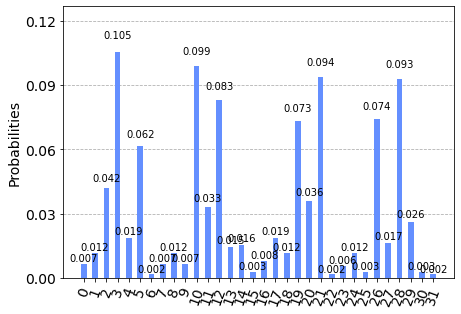

In [15]:
plot_histogram(sample_bitstrings(circuit))

In [16]:
def sample_bitstrings_simulator(circuit, shots: int = 1024) -> Dict[int, int]:
    # Use Aer's qasm_simulator
    print("run simulator")
    circuit.name = ""

    if type(circuit) == cirq.circuits.circuit.Circuit:
        circuit = mitiq.interface.mitiq_qiskit.conversions.to_qiskit(circuit)

    backend_sim = Aer.get_backend('qasm_simulator')
    qi = QuantumInstance(backend=backend_sim,shots=shots)
    result = qi.execute(circuit)

    counts = result.get_counts()

    int_counts = {}
    for key in counts.keys():
        int_counts[int(key.replace(' ',''),2)] = counts[key]
    return int_counts

run simulator


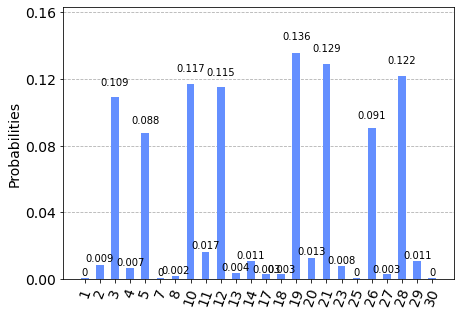

In [17]:
plot_histogram(sample_bitstrings_simulator(circuit))

### Observable to measure

In [18]:
# Observable(s) to measure.
operator, offset = qubo.to_ising()
print(f"offest: {offset}")
obs = np.real(np.diag(operator.to_matrix()))
obs

offest: -24.0


array([ 24.,   9.,   5., -10.,   8.,  -7.,   7.,  -8.,   8.,  11., -11.,
        -8.,  -8.,  -5.,  -9.,  -6.,  -6.,  -9.,  -5.,  -8.,  -8., -11.,
        11.,   8.,  -8.,   7.,  -7.,   8., -10.,   5.,   9.,  24.])

In [19]:
cdr.execute.calculate_observable(
    state_or_measurements=sample_bitstrings_simulator(circuit),
    observable=obs,
)

run simulator


-8.248046875

In [20]:
cdr.execute.calculate_observable(
    state_or_measurements=sample_bitstrings(circuit),
    observable=obs,
)

run noise


-5.83984375

### Execute CDR 

In [21]:
exp = cdr.execute_with_cdr(
    circuit=circuit,
    executor=sample_bitstrings,
    observables=[obs],
    simulator=sample_bitstrings_simulator,
)
exp

run noise
run noise
run noise
run noise
run noise
run noise
run noise
run noise
run noise
run noise
run noise
run simulator


[-6.898437500000001]

In [22]:
# add offset -> real expectation value?
exp[0] + offset

-30.8984375

### Questions

- 'cdr.execute_with_cdr' liefert nur einen Wert zurück -> somit nicht möglich auf die Verteilung zu schließen. 
- 'cdr.execute_with_cdr' müsste doch so angepasst werden, dass es einen eigenvector/eigenstate zurückliefert? <br>
   Diesen könnte man wie in https://github.com/Qiskit/qiskit-optimization/blob/3f944c4c795d98006704908b62391412a90ad0d5/qiskit_optimization/algorithms/optimization_algorithm.py#L510 auswerten:
   
```
solutions = []
eigenvector = # von cdr 
num_qubits = int(np.log2(eigenvector.size))
probabilities = np.abs(eigenvector * eigenvector.conj())

# iterate over all states and their sampling probabilities
for i, sampling_probability in enumerate(probabilities):
    # add the i-th state if the sampling probability exceeds the threshold
    if sampling_probability >= 1e-9:
        bitstr = f"{i:b}".rjust(num_qubits, "0")
        solutions.append(generate_solution(bitstr, max_cut_qubo, sampling_probability))
        
```

### Papers:
- https://arxiv.org/pdf/2005.10189.pdf 